# makemore: part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random

random.seed(42)
random.shuffle(words)

In [40]:
# build the dataset

block_size = 8  # context length: how many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

In [41]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "--->", itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


## Problem with MLP: information is squashed too quickly
i.e. characters are squashed into 1 vector immediately <br/>
**Wavenet:** fuse inputs progressively


In [ ]:
# prepare to be surpised...
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [ ]:
# surprise!!!
# the matrix multiplication works on the last dimension, the dims before it in the input tensor are unchanged, treated as batch dimensions
(torch.randn(4, 5, 3, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 3, 200])

In [ ]:
# (1 2) (3 4) (5 6) (7 8)  "batch dimension"

In [ ]:
(torch.randn(4, 80).view(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape
# 4 examples, 4 groups of 2 chars each (8 chars in total), 20 dim embed vector (2 chars * 10)

torch.Size([4, 4, 200])

In [ ]:
e = torch.randn(4, 8, 10)  # goal: want this to be (4, 4, 20)  where consecutive 10-d vectors get concatenated
# e[:, ::2, :] is getting all the even tensors, e[:, 1::2, :] all odd ones
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [85]:
# Near copy paste of the layers we have developed in Part 3
# ------------------------------------------------------------------
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        if self.bias is None:
            return [self.weight]
        return [self.weight, self.bias]


# ------------------------------------------------------------------
# note: pytorch batchnorm1d takes input to call in the shape of either (N, C) or (N, C, L), whereas
# the shapes we accept here are (N, C) or (N, L, C)
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError
            # xmean = x.mean(0, keepdim=True)
            xmean = x.mean(dim, keepdim=True)
            # xvar = x.var(0, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# ------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


# ------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


# ------------------------------------------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


# ------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


# ------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [32]:
torch.manual_seed(42);  # seed rng for reproducibility

In [78]:
n_embd = 24  # dimensionality of the character embedding vectors
# n_hidden = 200  # number of neurons in the hidden layer of the MLP
n_hidden = 128  # number of neurons in the hidden layer of the WaveNet

# C = torch.randn((vocab_size, n_embd))
# layers = [
model = Sequential([
    Embedding(vocab_size, n_embd),
    # Flatten(),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # Linear(n_embd * block_size, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    # Tanh(),
    Linear(n_hidden, vocab_size),
])

# # parameter init
# with torch.no_grad():
#     layers[-1].weight *= 0.1  # last layer: make less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [76]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  1,  2,  8,  9, 13,  1],
        [ 0,  0,  0, 22,  1, 18, 19,  8],
        [ 0,  0, 13,  1,  3,  9,  5, 10],
        [ 0,  0,  0,  0, 14,  5, 12,  9]])

In [77]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [73]:
logits.shape

torch.Size([4, 27])

In [44]:
model.layers[0].out.shape  # output of Embedding layer

torch.Size([4, 8, 10])

In [45]:
model.layers[1].out.shape  # output of Flatten layer

torch.Size([4, 80])

In [46]:
model.layers[2].out.shape  # output of Linear layer

torch.Size([4, 200])

In [81]:
# problem with batchnorm1d:
e = torch.randn(32, 4, 68)
# emean = e.mean(0, keepdim=True)  # 1, 4, 68
emean = e.mean((0, 1), keepdim=True)  # 1, 1, 68
# evar = e.var(0, keepdim=True)  # 1, 4, 68
evar = e.var((0, 1), keepdim=True)  # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [82]:
emean.shape

torch.Size([1, 1, 68])

In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    # emb = C[Xb]  # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    # loss = F.cross_entropy(x, Yb)  # loss function
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.4915
  10000/ 200000: 2.2179
  20000/ 200000: 2.3681
  30000/ 200000: 2.1342
  40000/ 200000: 2.4067
  50000/ 200000: 2.2406
  60000/ 200000: 1.9608
  70000/ 200000: 1.9236
  80000/ 200000: 2.6587
  90000/ 200000: 2.0502
 100000/ 200000: 2.2596
 110000/ 200000: 1.6270
 120000/ 200000: 2.1705
 130000/ 200000: 2.2806
 140000/ 200000: 2.1980
 150000/ 200000: 1.8434
 160000/ 200000: 1.8251
 170000/ 200000: 2.3077
 180000/ 200000: 2.0817
 190000/ 200000: 2.1585


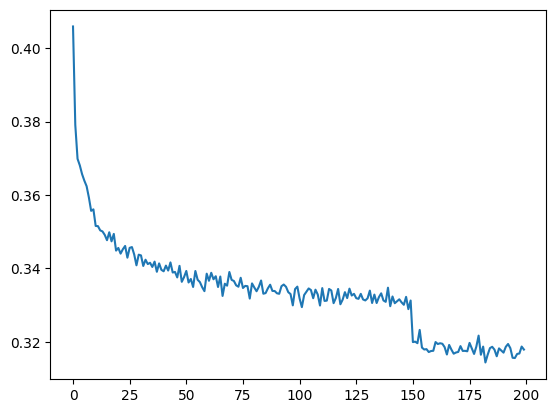

In [27]:
# average of every 1000 steps
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [37]:
# put layers into eval mode (especially for batchnorm)
# for layer in layers:
for layer in model.layers:
    layer.training = False

In [35]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    # emb = C[x]  # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    # loss = F.cross_entropy(x, y)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.057539939880371
val 2.1039814949035645


#### Performance log
- original (3 char context + 200 hidden neurons, 12k params): train 2.058, val 2.105
- context 3 -> 8 (22k params): train 1.918, val 2.027
- flat -> hierarchical (22k params): train 1.941, val 2.029
- fix dim bug in batchnorm: train 1.912, val 2.022
- scale up the network (n_embd 24, n_hidden 128, 76k params): 1.769, 1.993

In [39]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

damiara.
alyzani.
haylian.
freslyn.
safia.
rein.
jastiegon.
cani.
aini.
zaydentyn.
axley.
jere.
grancealynna.
jamaurole.
farashton.
sabigianner.
tyre.
dia.
beir.
damelays.


### Next time:
Why convolutions? Brief preview/hint

In [86]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [87]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [88]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space